## Import Packages

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import datetime as dt
warnings.filterwarnings('ignore')

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

## Đọc dữ liệu

In [3]:
retail_df = pd.read_csv("/kaggle/input/online-retail-customer-clustering/OnlineRetail.csv", encoding='latin-1')
retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


## Làm sạch dữ liệu

In [5]:
retail_df = retail_df[retail_df['Quantity'] > 0]
retail_df = retail_df[retail_df['UnitPrice'] > 0]
retail_df = retail_df[retail_df['CustomerID'].notnull()]

## Xử lý dữ liệu
**Dựa trên RFM (Recency, Frequency, Monetary)**

In [6]:
# Monetary

retail_df['Amount'] = retail_df['Quantity']*retail_df['UnitPrice']
rfm_m = retail_df.groupby('CustomerID')['Amount'].sum()
rfm_m = rfm_m.reset_index()
rfm_m.head()

,CustomerID,Amount
0,12346.0,77183.60
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


In [12]:
# Frequency

rfm_f = retail_df.groupby('CustomerID')['InvoiceNo'].count()
rfm_f = rfm_f.reset_index()
rfm_f.columns = ['CustomerID', 'Frequency']
rfm_f.head()

,CustomerID,Frequency
0,12346.0,1
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17


In [10]:
# Recency

retail_df['InvoiceDate'] = pd.to_datetime(retail_df['InvoiceDate'],format='%d-%m-%Y %H:%M')
max_date = max(retail_df['InvoiceDate'])
retail_df['Diff'] = max_date - retail_df['InvoiceDate']

rfm_p = retail_df.groupby('CustomerID')['Diff'].min()
rfm_p = rfm_p.reset_index()
rfm_p['Diff'] = rfm_p['Diff'].dt.days
rfm_p.head()

,CustomerID,Diff
0,12346.0,325
1,12347.0,1
2,12348.0,74
3,12349.0,18
4,12350.0,309


In [13]:
rfm = pd.merge(rfm_m, rfm_f, on='CustomerID', how='inner')
rfm = pd.merge(rfm, rfm_p, on='CustomerID', how='inner')
rfm.columns = ['CustomerID', 'Amount', 'Frequency', 'Recency']
rfm.head()

,CustomerID,Amount,Frequency,Recency
0,12346.0,77183.60,1,325
1,12347.0,4310.00,182,1
2,12348.0,1797.24,31,74
3,12349.0,1757.55,73,18
4,12350.0,334.40,17,309


Text(0.5, 0, 'Attributes')

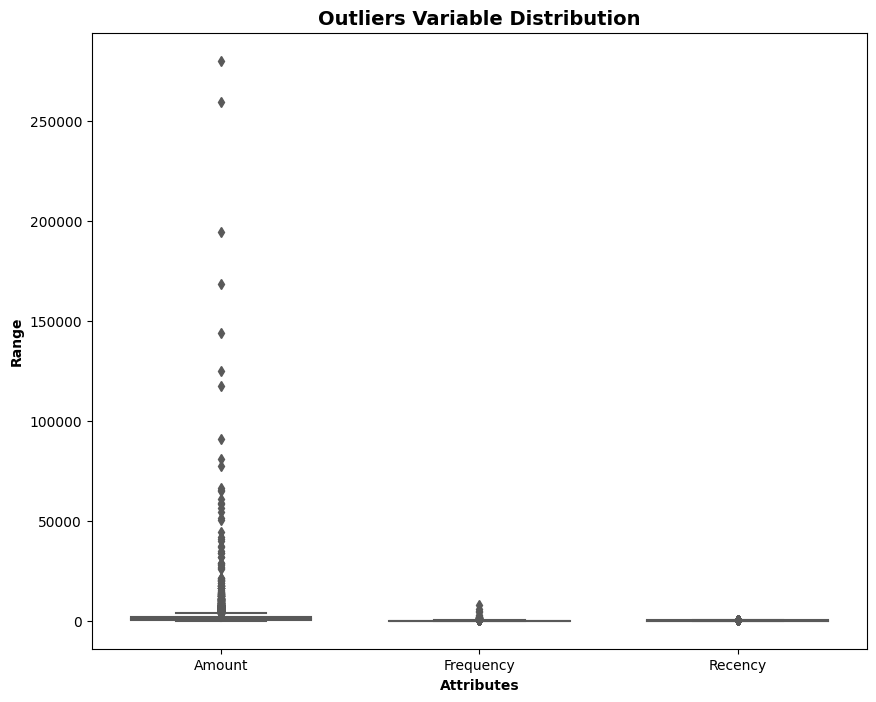

In [14]:
# Outlier Analysis

attributes = ['Amount','Frequency','Recency']
plt.rcParams['figure.figsize'] = [10,8]
sns.boxplot(data = rfm[attributes], orient="v", palette="Set2" ,whis=1.5,saturation=1, width=0.7)
plt.title("Outliers Variable Distribution", fontsize = 14, fontweight = 'bold')
plt.ylabel("Range", fontweight = 'bold')
plt.xlabel("Attributes", fontweight = 'bold')

In [16]:
# Removing (statistical) outliers for Amount
Q1 = rfm.Amount.quantile(0.05)
Q3 = rfm.Amount.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.Amount >= Q1 - 1.5*IQR) & (rfm.Amount <= Q3 + 1.5*IQR)]

# Removing (statistical) outliers for Recency
Q1 = rfm.Recency.quantile(0.05)
Q3 = rfm.Recency.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.Recency >= Q1 - 1.5*IQR) & (rfm.Recency <= Q3 + 1.5*IQR)]

# Removing (statistical) outliers for Frequency
Q1 = rfm.Frequency.quantile(0.05)
Q3 = rfm.Frequency.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.Frequency >= Q1 - 1.5*IQR) & (rfm.Frequency <= Q3 + 1.5*IQR)]

In [17]:
#Rescaling

rfm_df = rfm[['Amount', 'Frequency', 'Recency']]

scaler = StandardScaler()

# fit_transform
rfm_df_scaled = scaler.fit_transform(rfm_df)
rfm_df_scaled.shape

(4232, 3)

In [18]:
rfm_df_scaled = pd.DataFrame(rfm_df_scaled)
rfm_df_scaled.columns = ['Amount', 'Frequency', 'Recency']
rfm_df_scaled.head()

,Amount,Frequency,Recency
0,1.855416,1.140452,-0.922106
1,0.323781,-0.462920,-0.194096
2,0.299589,-0.016949,-0.752570
3,-0.567882,-0.611577,2.149498
4,0.755825,0.110472,-0.583033


## Phân loại khách hàng

In [23]:
#Phân loại theo RFM, vì vậy ta chọn số clusters là 3
kmeans_cluster = KMeans(n_clusters=3,n_init='auto',random_state=42).fit(rfm_df_scaled)

In [24]:
rfm_df_scaled['cluster_labels'] = kmeans_cluster.labels_

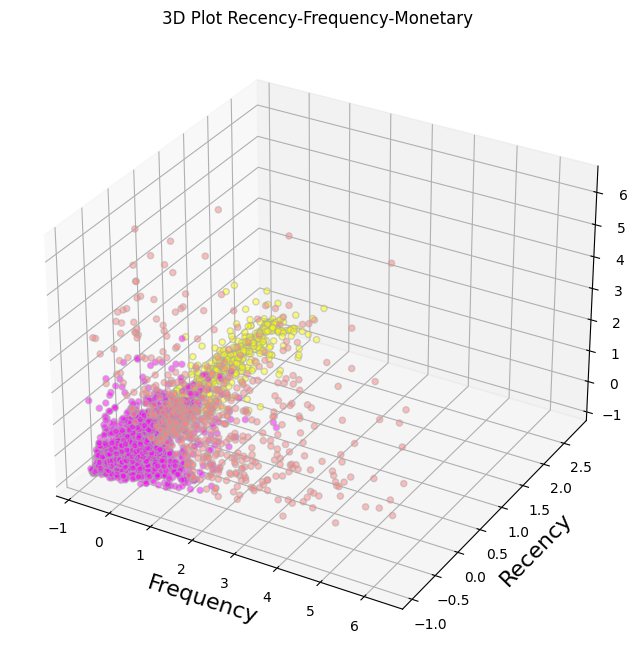

In [28]:
from mpl_toolkits.mplot3d import Axes3D 
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(rfm_df_scaled['Frequency'],rfm_df_scaled['Recency'],rfm_df_scaled['Amount'],c=rfm_df_scaled['cluster_labels'],cmap='spring',alpha=0.5,edgecolor='darkgrey')
ax.set_xlabel('Frequency',fontsize=16)
ax.set_ylabel('Recency',fontsize=16)
ax.set_zlabel('Monetary',fontsize=16)
plt.title('3D Plot Recency-Frequency-Monetary')
plt.show()